In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

# Download the 'cats_vs_dogs' dataset

In [2]:
ds_train, ds_info = tfds.load(
    'cats_vs_dogs',
    split='train',
    with_info=True,
    as_supervised=True,
)

In [3]:
class_name = ['cat', 'dog']

In [4]:
ds_train_ = ds_train.shuffle(buffer_size=10000, reshuffle_each_iteration=False)
num_train_examples = int(0.7 * len(ds_train))
ds_train = ds_train_.take(num_train_examples)
ds_test = ds_train_.skip(num_train_examples)

In [5]:
IMG_SIZE = 160
BATCH_SIZE = 64

In [6]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, tf.one_hot(label, depth=2)

In [7]:
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

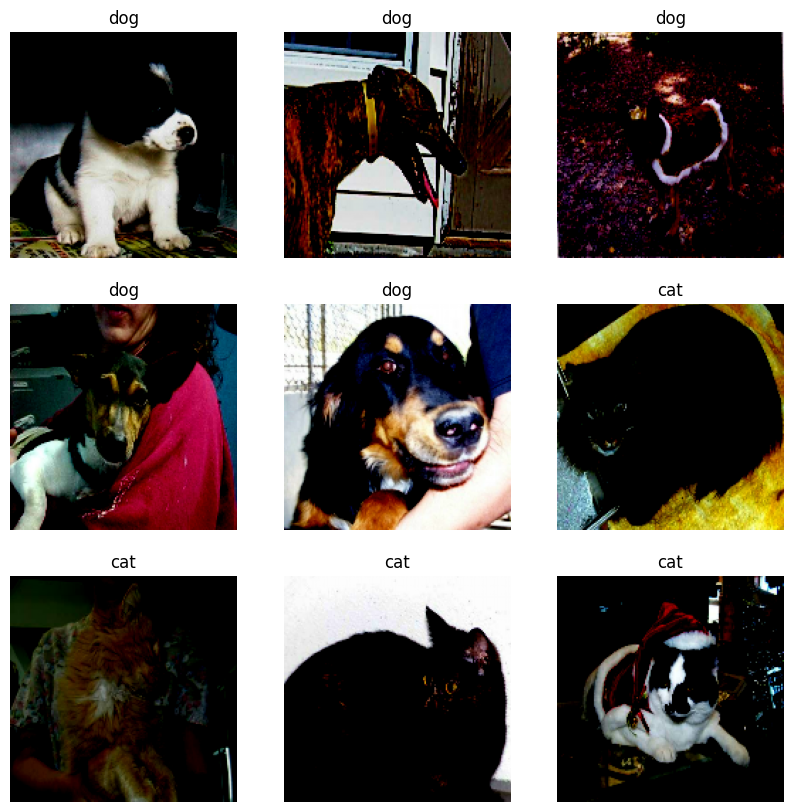

In [9]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].numpy())
    plt.title(class_name[np.argmax(label[0])])
    plt.axis("off")

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from keras import regularizers, optimizers

In [11]:
def get_model(base_hidden_units=32, weight_decay=1e-4):
    md = Sequential()

    # CONV_1
    md.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay),
                  input_shape=(160, 160, 3)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_2
    md.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(3,3)))
    md.add(Dropout(0.2))

    # CONV_3
    md.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_4
    md.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(3,3)))
    md.add(Dropout(0.3))

    # CONV_5
    md.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_6
    md.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(2,2)))
    md.add(Dropout(0.4))

    # FC_7
    md.add(Flatten())
    md.add(Dense(2, activation='softmax'))

    return md

In [12]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 activation (Activation)     (None, 160, 160, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 160, 160, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                        

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])

In [14]:
history = model.fit(ds_train, validation_data=ds_test, epochs=25)

Epoch 1/25
255/255 [==============================] - 48s 150ms/step - loss: 1.3126 - accuracy: 0.6267 - val_loss: 1.1925 - val_accuracy: 0.4943
Epoch 2/25
255/255 [==============================] - 39s 147ms/step - loss: 0.8137 - accuracy: 0.7072 - val_loss: 0.6993 - val_accuracy: 0.6898
Epoch 3/25
255/255 [==============================] - 39s 148ms/step - loss: 0.6563 - accuracy: 0.7609 - val_loss: 0.6529 - val_accuracy: 0.7732
Epoch 4/25
255/255 [==============================] - 39s 150ms/step - loss: 0.6009 - accuracy: 0.8002 - val_loss: 1.4532 - val_accuracy: 0.6750
Epoch 5/25
255/255 [==============================] - 39s 147ms/step - loss: 0.5247 - accuracy: 0.8287 - val_loss: 0.5474 - val_accuracy: 0.8109
Epoch 6/25
255/255 [==============================] - 39s 147ms/step - loss: 0.4779 - accuracy: 0.8550 - val_loss: 0.3927 - val_accuracy: 0.8667
Epoch 7/25
255/255 [==============================] - 39s 149ms/step - loss: 0.4104 - accuracy: 0.8754 - val_loss: 0.5314 - val_ac

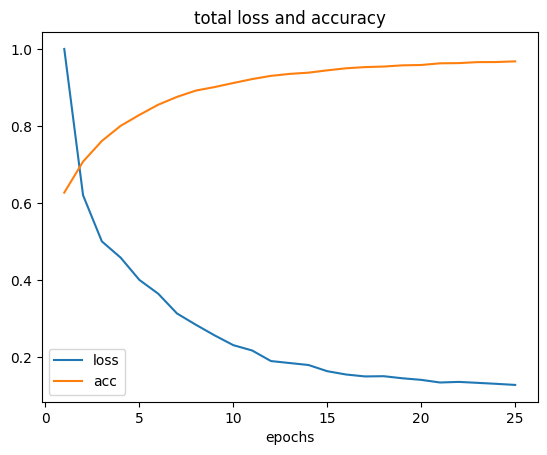

In [15]:
import matplotlib.pyplot as plt
import numpy as np

epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
acc_array = history.history['accuracy']

max_loss = max(loss_array)
loss_array = np.array(loss_array) / max_loss

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, acc_array, label="acc")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

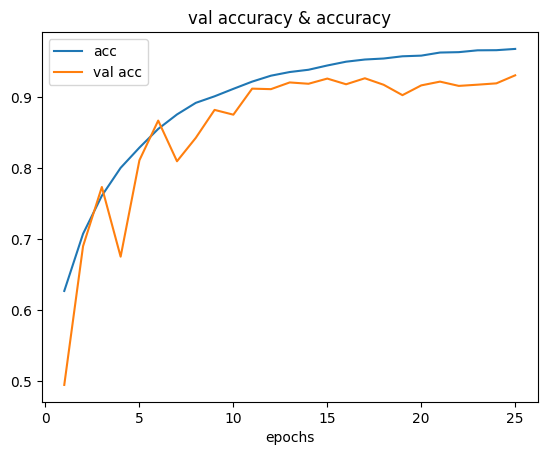

In [16]:
epoch_array = range(1, len(history.history['loss']) + 1)
val_acc_array = history.history['val_accuracy']
acc_array = history.history['accuracy']

plt.plot(epoch_array, acc_array, label="acc")
plt.plot(epoch_array, val_acc_array, label="val acc")
plt.xlabel("epochs")
plt.title("val accuracy & accuracy")

plt.legend()
plt.show()

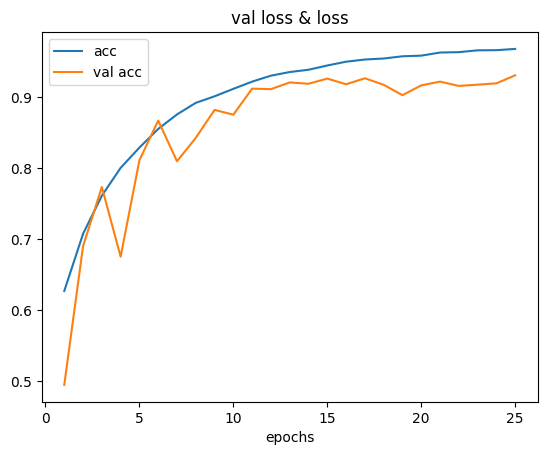

In [17]:
epoch_array = range(1, len(history.history['loss']) + 1)
val_acc_array = history.history['val_accuracy']
acc_array = history.history['accuracy']

plt.plot(epoch_array, acc_array, label="acc")
plt.plot(epoch_array, val_acc_array, label="val acc")
plt.xlabel("epochs")
plt.title("val loss & loss")

plt.legend()
plt.show()

In [18]:
results = model.evaluate(ds_test)
print(results)

110/110 [==============================] - 9s 38ms/step - loss: 0.3083 - accuracy: 0.9305
[0.3082512617111206, 0.9305058121681213]


In [19]:
from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

219/219 [==============================] - 4s 15ms/step


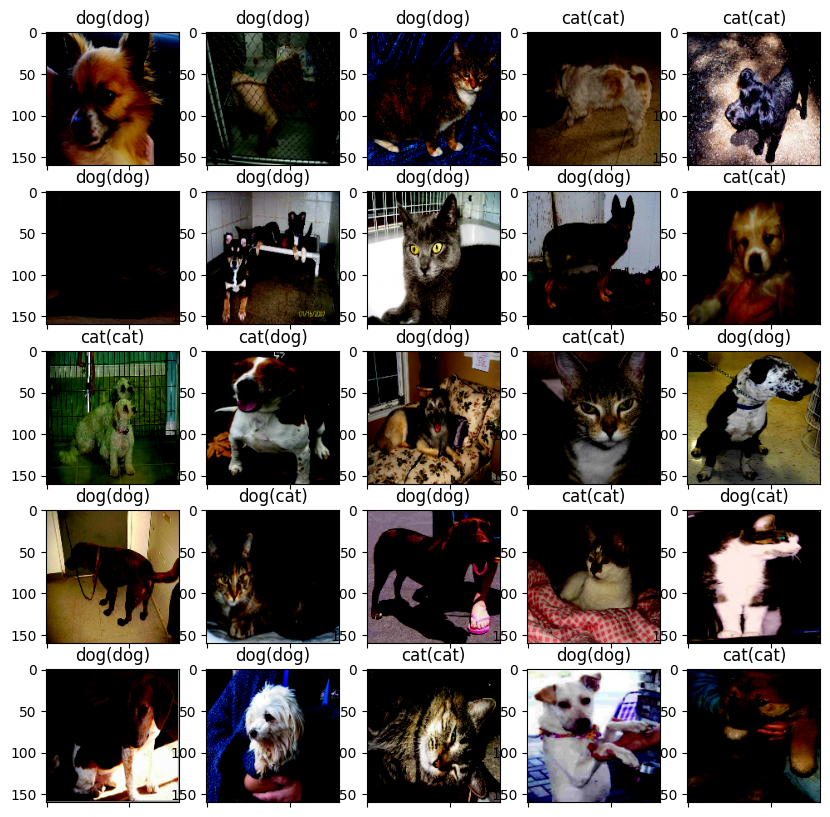

In [20]:
# finally visualize it
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

test_pred = model.predict(x_test)

for idx, elem in enumerate(ds_test.take(25)):
    pred_idx = np.argmax(test_pred[idx])
    true_idx = np.argmax(y_test[idx])
    plt.subplot(5, 5, idx + 1, title=(class_name[pred_idx] + "(" + class_name[true_idx] + ")"))
    plt.imshow(elem[0][0].numpy())

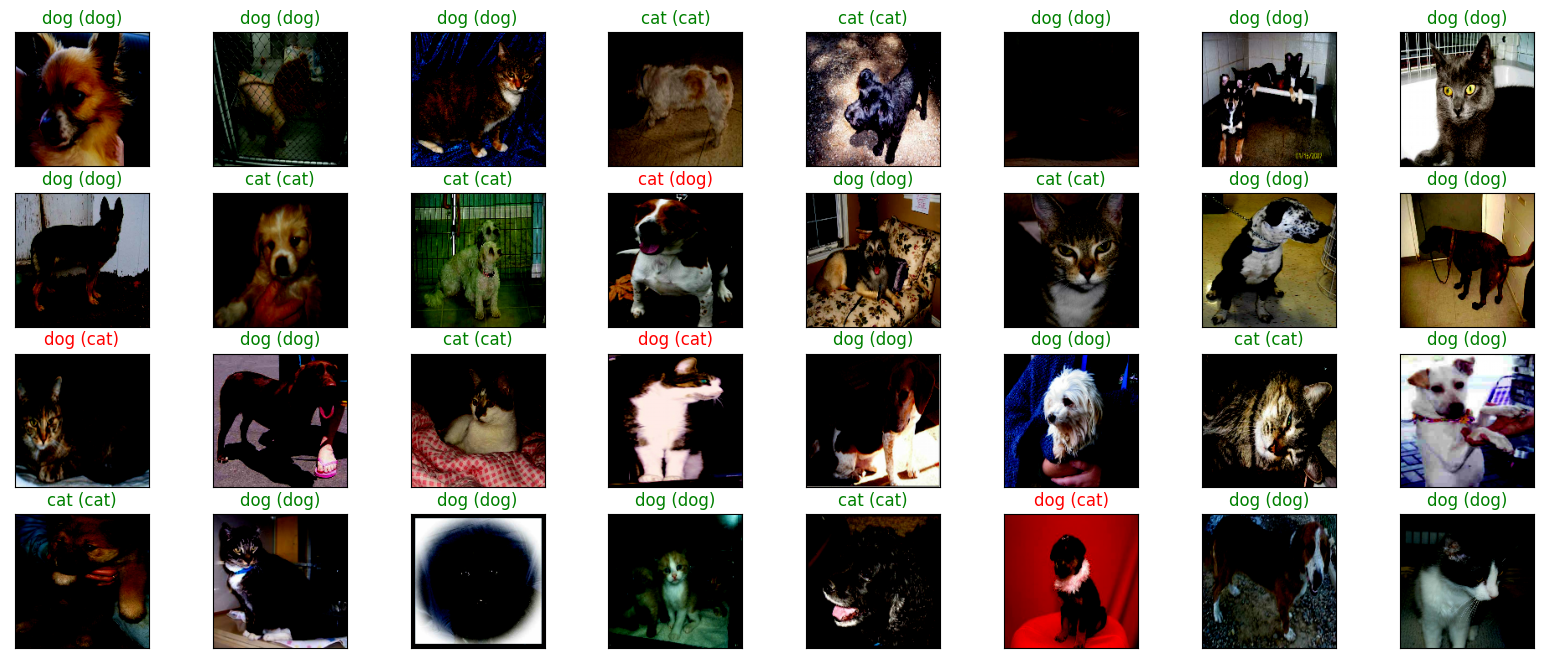

In [21]:
from matplotlib import pyplot

fig = pyplot.figure(figsize=(20, 8))

for idx, elem in enumerate(ds_test.take(32)):
    ax = fig.add_subplot(4, 8, idx + 1, xticks=[], yticks=[])
    ax.imshow(elem[0][0].numpy())
    pred_idx = np.argmax(test_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(class_name[pred_idx], class_name[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
pyplot.show()